## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBBSBS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
942
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|3255.9381788602113|-563.8355681800143|-189.58171068737818|    240.8|BBBBBSBS|    43.9|    -71.3|       SNWD|0.11881505172944894|0.09238976506184808|0.08940226690972031|  0.401594

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00278612|    43.9|    -71.3|    240.8|3255.9381788602113|
|USC00274475|   43.55| -71.4667|    170.7|3592.8010358972265|
|USC00172238| 43.8786| -70.7539|    160.9| 5527.301733677776|
|US1MECM0020| 43.6711|  -70.441|     69.8|   2261.7382339656|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
71,US1MECM0007,43.7440,-70.4890,44.8,1,2332.291485
56,US1MECM0018,43.7029,-70.3055,19.2,1,1157.187822


In [87]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))
get_color(-1000.)

u'#0000d6'

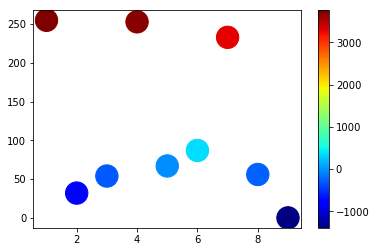

In [86]:
l = [(rgb2hex(cmap(x)[:3])) for x in np.arange(0,1,0.01)]
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [255, 32, 54, 253, 67, 87, 233, 56, 0]

color = [(_min+((_max-_min)*item / 255.0)) for item in y]
jet_map = plt.get_cmap('jet')

plt.figure()
plt.scatter(x, y, s = 500, c = color, cmap = jet_map)
plt.colorbar()
plt.show()


## Map

In [75]:
print np.arange(_min,_max+1,(_max-_min)/9)
print _min, _max
#df2=df1.filter("longitude!=-66.083")

[-1386.69814846  -815.47477395  -244.25139945   326.97197506   898.19534957
  1469.41872407  2040.64209858  2611.86547309  3183.08884759  3754.3122221 ]
-1386.69814846 3754.3122221


In [41]:
df2.describe().show()

+-------+-----------+------------------+------------------+------------------+------------------+-------------------+
|summary|    station|          latitude|         longitude|         elevation|    count(station)|       avg(coeff_1)|
+-------+-----------+------------------+------------------+------------------+------------------+-------------------+
|  count|         86|                86|                86|                86|                86|                 86|
|   mean|       null|43.408281395348844|-70.98736162790698| 95.00116279069766|10.953488372093023|  748.3060336970447|
| stddev|       null|0.4347747161087469| 0.509804149053944|143.65132745987748|10.048010604087915|   980.008086762716|
|    min|US1MECM0007|           42.6408|            -71.65|            -999.9|                 1|-1386.6981484587784|
|    max|USW00014764|           44.0303|          -69.2622|             335.9|                43| 3754.3122221015515|
+-------+-----------+------------------+----------------

In [42]:
min_lat,max_lat,min_long,max_long = box = (42.6408, 44.0303, -71.65, -69.2622)

In [88]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#000', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [ ]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');